# Let's put that lesson into practice 🔍

## First things first

#### Load the library (and a couple of others)

In [1]:
import re

import pandas as pd
import pdfplumber

#### Open the PDF

In [2]:
pdf = pdfplumber.open("../pdfs/01-practice.pdf")

#### How many pages in the PDF?

In [3]:
len(pdf.pages)

1

#### Select that first/only page

In [4]:
page = pdf.pages[0]
page

<Page:1>

## What does the page look like?

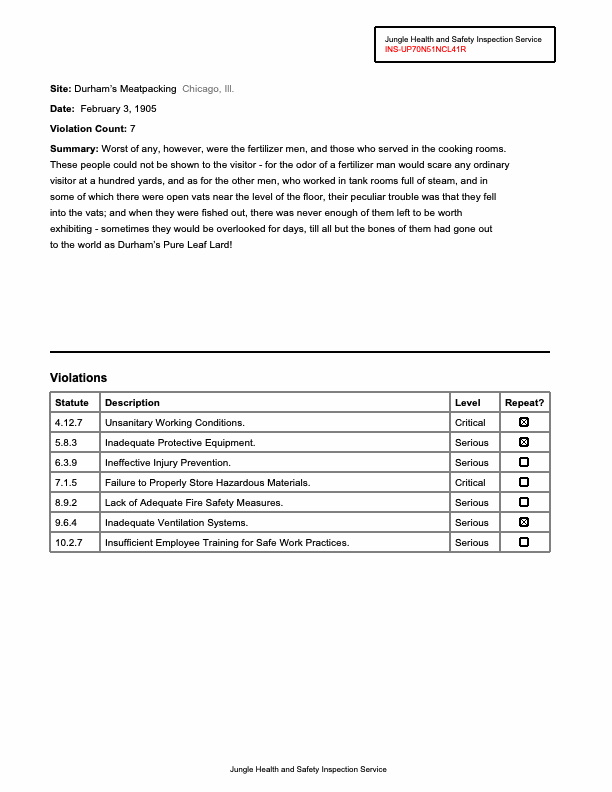

In [5]:
im = page.to_image()
im

## Let's extract the text

#### The "plain" way, which we learned in the previous notebook

In [6]:
print(page.extract_text())

Jungle Health and Safety Inspection Service
INS-UP70N51NCL41R
Site: Durham’s Meatpacking Chicago, Ill.
Date: February 3, 1905
Violation Count: 7
Summary: Worst of any, however, were the fertilizer men, and those who served in the cooking rooms.
These people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary
visitor at a hundred yards, and as for the other men, who worked in tank rooms full of steam, and in
some of which there were open vats near the level of the floor, their peculiar trouble was that they fell
into the vats; and when they were fished out, there was never enough of them left to be worth
exhibiting - sometimes they would be overlooked for days, till all but the bones of them had gone out
to the world as Durham’s Pure Leaf Lard!
Violations
Statute Description Level Repeat?
4.12.7 Unsanitary Working Conditions. Critical
5.8.3 Inadequate Protective Equipment. Serious
6.3.9 Ineffective Injury Prevention. Serious
7.1.5 Failure to Pro

#### The "layout" way

If you set `layout=True`, then `.extract_text(...)` attempts to mimic the layout of the original text. As you'll see, it does a *decent* but not perfect job.

In [7]:
print(page.extract_text(layout=True))

                                                                                    
                                                                                    
                                                                                    
                                                     Jungle Health and Safety Inspection Service
                                                     INS-UP70N51NCL41R              
                                                                                    
       Site: Durham’s Meatpacking Chicago, Ill.                                     
                                                                                    
       Date: February 3, 1905                                                       
                                                                                    
       Violation Count: 7                                                           
       Summary: Worst of any, however, were the ferti

## Let's start visual debugging

Visual debugging is typically the first thing I do when I'm working with a PDF for the first time. 

First, let's examine the structural parts of the page: Where are the characters, rectangles, and lines?

#### Characters

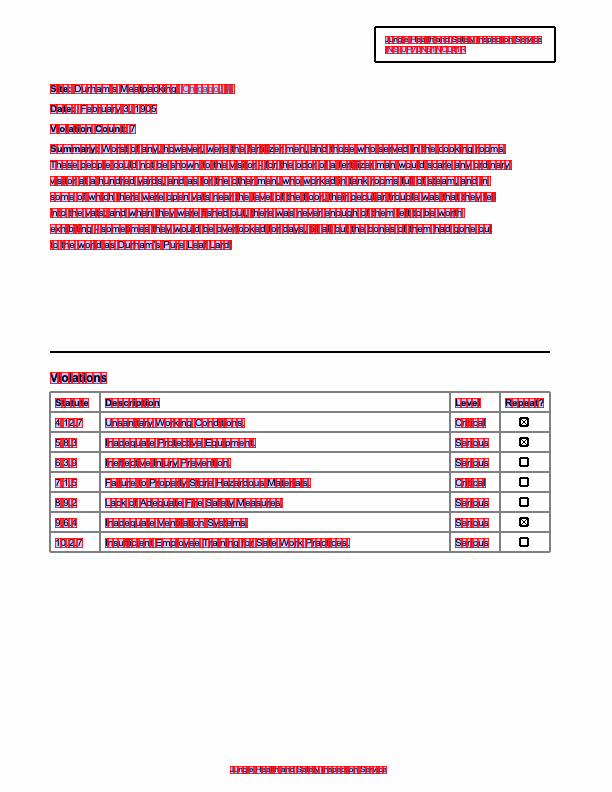

In [8]:
im.reset().draw_rects(page.chars)

#### Rectangles

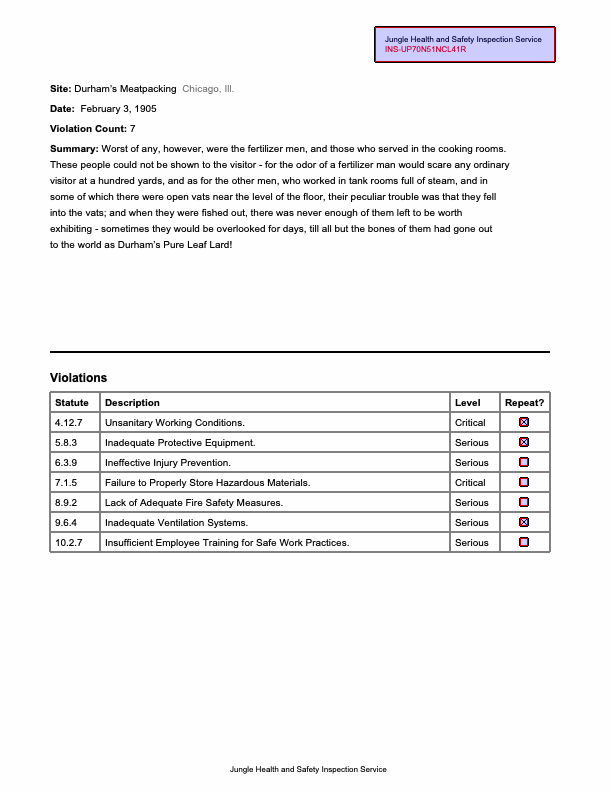

In [9]:
im.reset().draw_rects(page.rects)

#### Lines

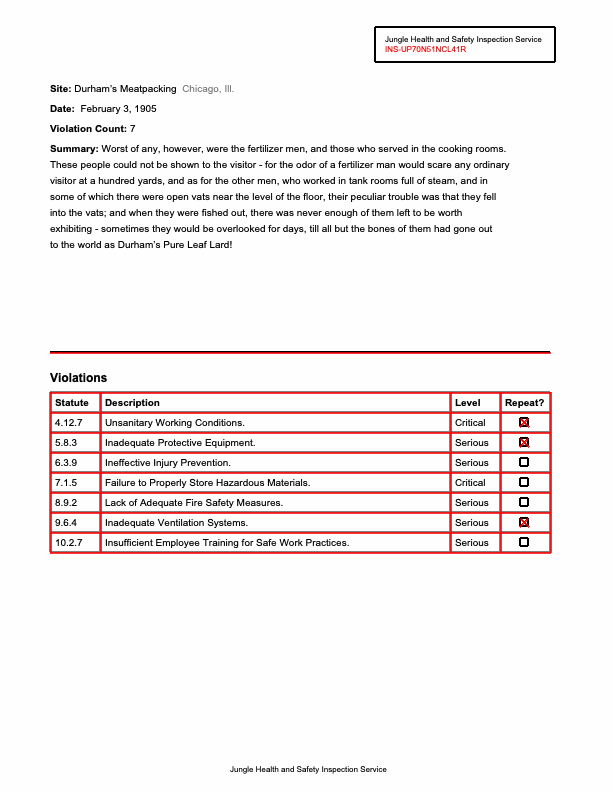

In [10]:
im.reset().draw_lines(page.lines, stroke_width=2)

#### Here's something we haven't seen before: `.debug_tablefinder(...)`

`pdfplumber` comes with a set of features for identifying and extracting tables on a given page. `PageImage.debug_tablefinder(...)` shows you what the table-finding method sees:

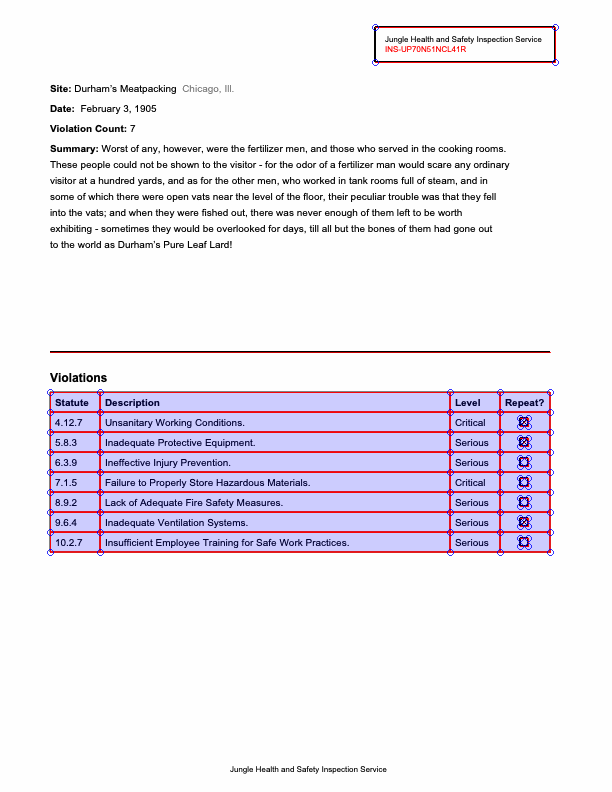

In [11]:
im.reset().debug_tablefinder()

## Let's extract that table!

(Note: Not all tables are so simple and explicit. See `pdfplumber`'s [table-extraction documentation](https://github.com/jsvine/pdfplumber#extracting-tables) to learn how to extract more difficult tables.)

#### All tables (in this example, there's only one)

In [12]:
page.extract_tables()

[[['Statute', 'Description', 'Level', 'Repeat?'],
  ['4.12.7', 'Unsanitary Working Conditions.', 'Critical', ''],
  ['5.8.3', 'Inadequate Protective Equipment.', 'Serious', ''],
  ['6.3.9', 'Ineffective Injury Prevention.', 'Serious', ''],
  ['7.1.5', 'Failure to Properly Store Hazardous Materials.', 'Critical', ''],
  ['8.9.2', 'Lack of Adequate Fire Safety Measures.', 'Serious', ''],
  ['9.6.4', 'Inadequate Ventilation Systems.', 'Serious', ''],
  ['10.2.7',
   'Insufficient Employee Training for Safe Work Practices.',
   'Serious',
   '']]]

#### Just the largest table (and put it in a `pandas` `DataFrame`)

In [13]:
rows = page.extract_table()

pd.DataFrame(rows[1:], columns=rows[0])

,Statute,Description,Level,Repeat?
0,4.12.7,Unsanitary Working Conditions.,Critical,
1,5.8.3,Inadequate Protective Equipment.,Serious,
2,6.3.9,Ineffective Injury Prevention.,Serious,
3,7.1.5,Failure to Properly Store Hazardous Materials.,Critical,
4,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,
5,9.6.4,Inadequate Ventilation Systems.,Serious,
6,10.2.7,Insufficient Employee Training for Safe Work P...,Serious,


## Planning the rest of our extraction

What parts of the page do we want to grab? What strategies might we be able to use?

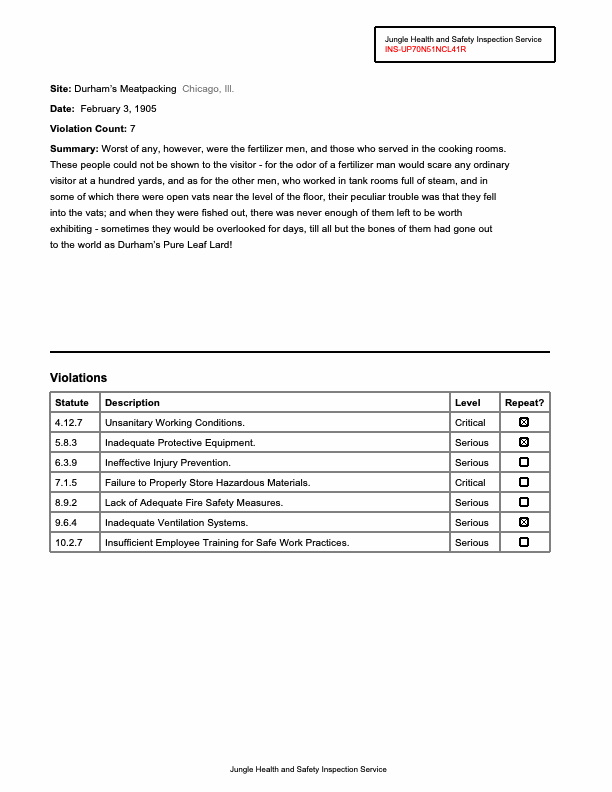

In [14]:
im.reset()

## Inspection ID

Let's start with the inspection ID, in the box at the top of the page. How might we get that? 

With PDFs, there's often more than one option. Let's explore a few!

#### __Option 1__: Just extract the text and parse it out of there.

We might feel confident, perhaps, that the text will always look something like this:

```
Jungle Health and Safety Inspection Service
{Inspection ID}
[...]
```

If that's a safe assumption, then straightforward text extraction should work fine. Here's the top part of the text:

In [15]:
text_simple = page.extract_text()
print(text_simple[:200])  # Printing just the initial chunk

Jungle Health and Safety Inspection Service
INS-UP70N51NCL41R
Site: Durham’s Meatpacking Chicago, Ill.
Date: February 3, 1905
Violation Count: 7
Summary: Worst of any, however, were the fertilizer men


... which you could parse with a [regular expression](https://www.w3schools.com/python/python_regex.asp):

In [16]:
insp_num_pat = r"Jungle Health and Safety Inspection Service\s+([^\n]+)"

insp_num_match = re.search(insp_num_pat, text_simple)

print(insp_num_match.group(1))

INS-UP70N51NCL41R


Huzzah! Alternatively, you could use `pdfplumber`'s built-in `Page.search(...)` method:

In [17]:
search_results = page.search(insp_num_pat)

first_match = search_results[0]

print(first_match["groups"][0])

INS-UP70N51NCL41R


&nbsp;
&nbsp;

#### __Option 2__: Cropping

What if you weren't so sure about that textual pattern? Maybe `Jungle Health and Safety Inspection Service` isn't the only inspection agency in your pile of PDFs? Or maybe there's sometimes a second line of text before the inspection number?

How about the box surrounding it? From the debugging we did above, we know that the box is defined as a rectangle, and perhaps we're pretty sure it'll always be the first one on the page. So let's take these steps, using the `Page.crop(...)` method we learned in the previous notebook:

1. Select the rectangle
2. Grab the rectangle's bounding box
2. Pass the bounding box to `page.crop(...)`
3. Extract the text

In [18]:
top_rect = page.rects[0]

top_rect_bbox = (top_rect["x0"], top_rect["top"], top_rect["x1"], top_rect["bottom"])

# Alternatively:
# top_rect_bbox = pdfplumber.utils.obj_to_bbox(top_rect)

print(top_rect_bbox)

(375, 27, 555, 62)


In [19]:
top_rect_cropped = page.crop(top_rect_bbox)

Let's check that the crop looks like what we intended:

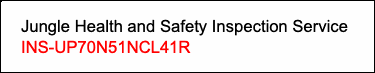

In [20]:
# Here, we pass an argument that increases the dimensions, for easier viewing
top_rect_cropped.to_image(resolution=150)

Great. Now, we can extract:

In [21]:
top_rect_text = top_rect_cropped.extract_text()

print(top_rect_text)

Jungle Health and Safety Inspection Service
INS-UP70N51NCL41R


... and grab the second line:

In [22]:
print(top_rect_text.split("\n")[-1])

INS-UP70N51NCL41R


&nbsp;
&nbsp;

#### __Option 3__: Filtering on character attributes

What if you weren't so sure about that, either? Maybe there's not always a box around the text, or maybe the inspection number sometimes comes *before* the agency name.

Perhaps you're more confident that, whatever the rest of the pattern, the inspection number will always show up in red? Let's try that. 

Text and graphical objects can have two types of colors: `stroking_color` (the outline) and `non_stroking_color` (the fill). With text, you're almost always looking for the `non_stroking_color`. 

Let's see what `non_stroking_color`s our text has:

In [23]:
char_colors = pd.DataFrame(page.chars)["non_stroking_color"].astype(str)

char_colors.value_counts()

non_stroking_color
(0,)         688
None         504
(1, 0, 0)     17
(0.5,)        13
Name: count, dtype: int64

As you can see, there are a few ways to specify color in PDFs. Let's break these down:

- `None`: The default color, black.
- `0`: A one-number specification refers to a grayscale color, on a continuum running from 0 (black) to 1 (white).
- `0.5`: Ditto. In this case, `0.5` is a gray halfway between white and black.
- `(1, 0, 0)`: A three-number tuple refers to an RGB color, with values for each item ranging from 0 to 1. This one here stands for full-red.

We're pretty sure it's last one we want, but let's make sure by using the visual debugging feature:

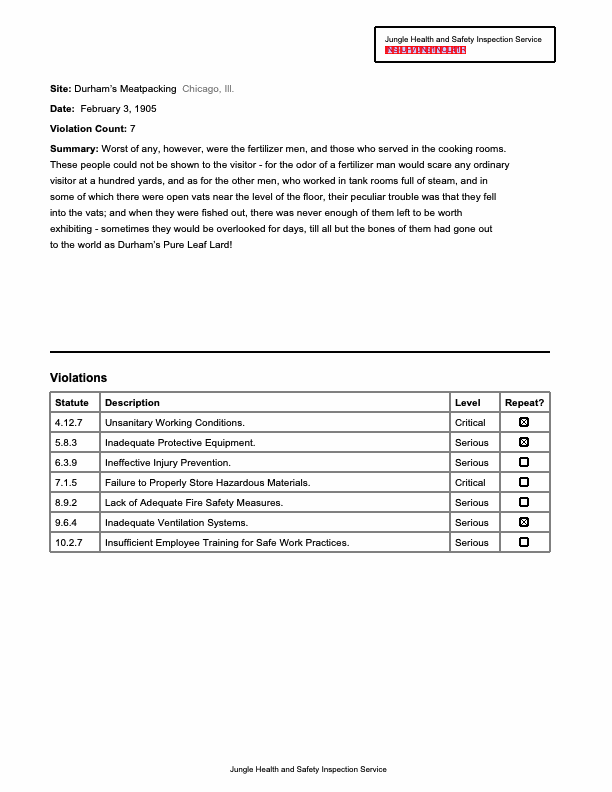

In [24]:
red_chars = [c for c in page.chars if c["non_stroking_color"] == (1, 0, 0)]

im.reset().draw_rects(red_chars)

Great! Now let's extract that, using a new method we haven't seen before: `Page.filter(...)`.

`Page.filter(...)` takes a function that will return `True` for objects we want to keep and `False` for those we want to ditch. So let's write that function and try it:

In [25]:
def is_red(obj):
    return obj.get("non_stroking_color") == (1, 0, 0)


filtered_page = page.filter(is_red)

print(filtered_page.extract_text())

INS-UP70N51NCL41R


It worked!

## Date, site, and violation count

For these fields, which each seem to be single-lined, we can probably safely just search by regular expression:

In [26]:
print(page.search(r"\nDate:\s+(.+?)\n")[0]["groups"][0])

February 3, 1905


In [27]:
print(page.search(r"\nSite:\s+(.+?)\n")[0]["groups"][0])

Durham’s Meatpacking Chicago, Ill.


In [28]:
print(page.search(r"\nViolation Count:\s+(.+?)\n")[0]["groups"][0])

7


Extra credit: How might you separate the site name (`Durham’s Meatpacking`) from its location (`Chicago, Ill.`)?

## Summary text

There's basically (other than the extra credit below), just one other part we need to grab: The summary text. Unlike the other chunks of text, it's multiline. We *could* use the `.search(...)` method above ... but where would we stop? We could stop at "Violations" ... but can we be sure that the summary text itself doesn't use that phrase?

Instead, let's try combining a few of the techniques we've picked up so far. We'll do this:

1. Identify where the summary begins
2. Identify the position of the horizontal line that separates the summary text from the violations section
3. Crop the page based on that information
4. Extract the text

#### Identify where the summary begins

`.search(...)` results each have positional information (`x0`, `top`, etc.) similar to other objects:

In [29]:
summary_match = page.search(r"\nSummary:")[0]

summary_match["top"]

144.07000000000005

In [30]:
summary_bbox = pdfplumber.utils.obj_to_bbox(summary_match)

summary_bbox

(50.0, 144.07000000000005, 98.9, 154.07000000000005)

#### Identify the position of the horizontal line

There are a number of ways to identify a line; in this case, we'll take advantage of the fact, that it's the only line that's 2 units thick:

In [31]:
pd.Series([x["linewidth"] for x in page.lines]).value_counts()

0.0    14
0.5     6
2.0     1
Name: count, dtype: int64

In [32]:
dividing_line = [x for x in page.lines if x["linewidth"] == 2][0]
dividing_line

{'x0': 50,
 'y0': 440,
 'x1': 550,
 'y1': 440,
 'width': 500,
 'height': 0,
 'pts': [(50, 352), (550, 352)],
 'linewidth': 2,
 'stroke': True,
 'fill': False,
 'evenodd': False,
 'stroking_color': (0,),
 'non_stroking_color': None,
 'object_type': 'line',
 'page_number': 1,
 'stroking_pattern': None,
 'non_stroking_pattern': None,
 'top': 352,
 'bottom': 352,
 'doctop': 352}

#### Let's confirm we got what we wanted

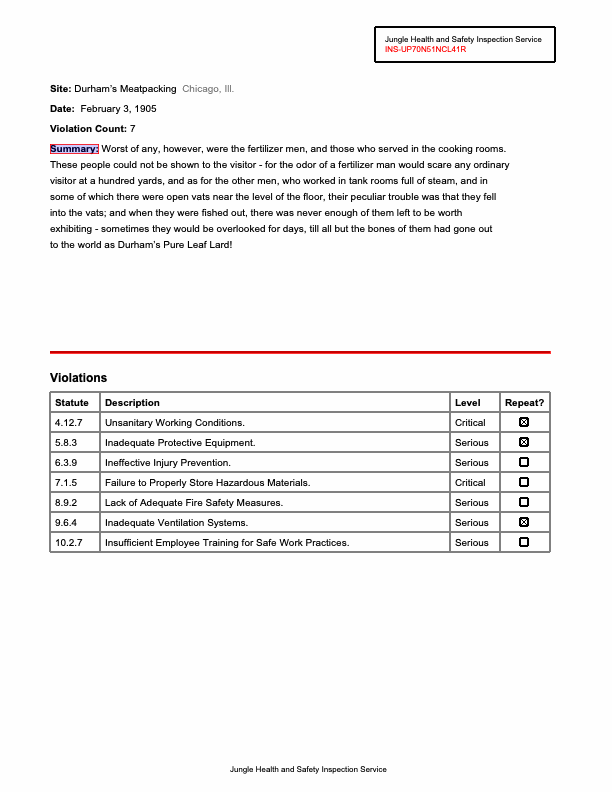

In [33]:
im.reset()

im.draw_rect(summary_bbox)

im.draw_line(dividing_line, stroke_width=3)

#### Crop the page based on that information

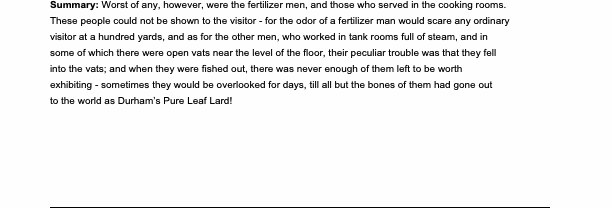

In [34]:
summary_crop = page.crop(
    (
        0,  # The left side of the page
        summary_match["top"],  # The top of the "Summary:" match
        page.width,  # The right side of the page
        dividing_line["top"],  # The top of the dividing line
    )
)

summary_crop.to_image()

#### Extract the text

In [35]:
print(summary_crop.extract_text())

Summary: Worst of any, however, were the fertilizer men, and those who served in the cooking rooms.
These people could not be shown to the visitor - for the odor of a fertilizer man would scare any ordinary
visitor at a hundred yards, and as for the other men, who worked in tank rooms full of steam, and in
some of which there were open vats near the level of the floor, their peculiar trouble was that they fell
into the vats; and when they were fished out, there was never enough of them left to be worth
exhibiting - sometimes they would be overlooked for days, till all but the bones of them had gone out
to the world as Durham’s Pure Leaf Lard!


## Extra-extra credit

In the violations table, how might you determine which rows have the `Repeat?` box checked?

---

---

---